In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# KE spectrum of surface velocities

In [2]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))

R4_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))
R4_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))

R4_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))

R32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False)
R32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', decode_times=False)
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_00002705.nc', decode_times=False).isel(time=slice(None,None,6))

In [3]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False)

M4_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False)
M4_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/longmean_00029050.nc', decode_times=False)

M4_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/longmean_00029050.nc', decode_times=False)

M32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-longmean.nc', decode_times=False)
M32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-longmean.nc', decode_times=False)
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [4]:
import xrft
def KE_spectrum(u, v, dx_mean=1):    
    x = dx_mean*np.arange(len(u.xh))
    u['xh'] = x
    v['xh'] = x
    
    spec = lambda val: xrft.power_spectrum(val, dim='xh', window='hann', nfactor=2,truncate=True, detrend='linear', window_correction=False)
    
    # KE is half the power spectrum
    sp = (spec(u) + spec(v))/2
    
    # Normalize to angular frequencies
    sp['freq_xh'] = sp['freq_xh'] * 2 * np.pi
    sp = sp / (2 * np.pi)
    freq = sp.freq_xh
    sp = sp.where(freq>0)
    
    return sp.mean('time').compute()

In [5]:
def SKE_spectrum(ds, ds_mean, u_factor=1):
    ssu = ds.u.isel(zl=0) - ds_mean.u.isel(zl=0).mean('time')
    ssv = ds.v.isel(zl=0) - ds_mean.v.isel(zl=0).mean('time')
    
    ssu = remesh(ssu, ds.h)
    ssv = remesh(ssv, ds.h)
    
    # remove 2.5 Lon from boundaries similarly to Marques
#     ssu = ssu.sel(xh = slice(2.5, 57.5))
#     ssv = ssv.sel(xh = slice(2.5, 57.5))
    
    if len(ds.xh)==240:
        dx_mean = 21383.6332011
    elif len(ds.xh)==1920:
        dx_mean = 21383.6332011 / 8
    else:
        print('Define dx_mean')
    
    return KE_spectrum(u_factor*ssu,ssv,dx_mean)

In [6]:
from dask.diagnostics import ProgressBar

In [15]:
with ProgressBar():
    R32_spec = SKE_spectrum(R32,M32)
    R32_spec_v = SKE_spectrum(R32,M32,u_factor=0)

[########################################] | 100% Completed | 26.09 s
[########################################] | 100% Completed | 22.83 ss


In [7]:
%%time 
with ProgressBar():
    R32_spec = SKE_spectrum(R32,M32)
    R32f_R1_spec = SKE_spectrum(R32f_R1,M32f_R1)
    R32f_R2_spec = SKE_spectrum(R32f_R2,M32f_R2)
    R4_spec = SKE_spectrum(R4,M4)
    smooth_weak_spec = SKE_spectrum(R4_smooth_weak,M4_smooth_weak)
    reynolds_weak_spec = SKE_spectrum(R4_reynolds_weak,M4_reynolds_weak)
    jh_spec = SKE_spectrum(R4_jh,M4_jh)
    yankovsky_weak_spec = SKE_spectrum(R4_yankovsky_weak,M4_yankovsky_weak)

[########################################] | 100% Completed | 25.40 ss
[########################################] | 100% Completed | 7.16 sms
[########################################] | 100% Completed | 6.99 sms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 906.35 ms
[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 806.92 ms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 805.89 ms
CPU times: user 47.2 s, sys: 41.4 s, total: 1min 28s
Wall time: 48.4 s


## Combined figure

In [8]:
yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

In [9]:
stats_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()

stats_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()

In [10]:
def KE(ds):
    return ds.KE.sum('Layer')
def APE(ds):
    return ds.APE.sum('Interface')

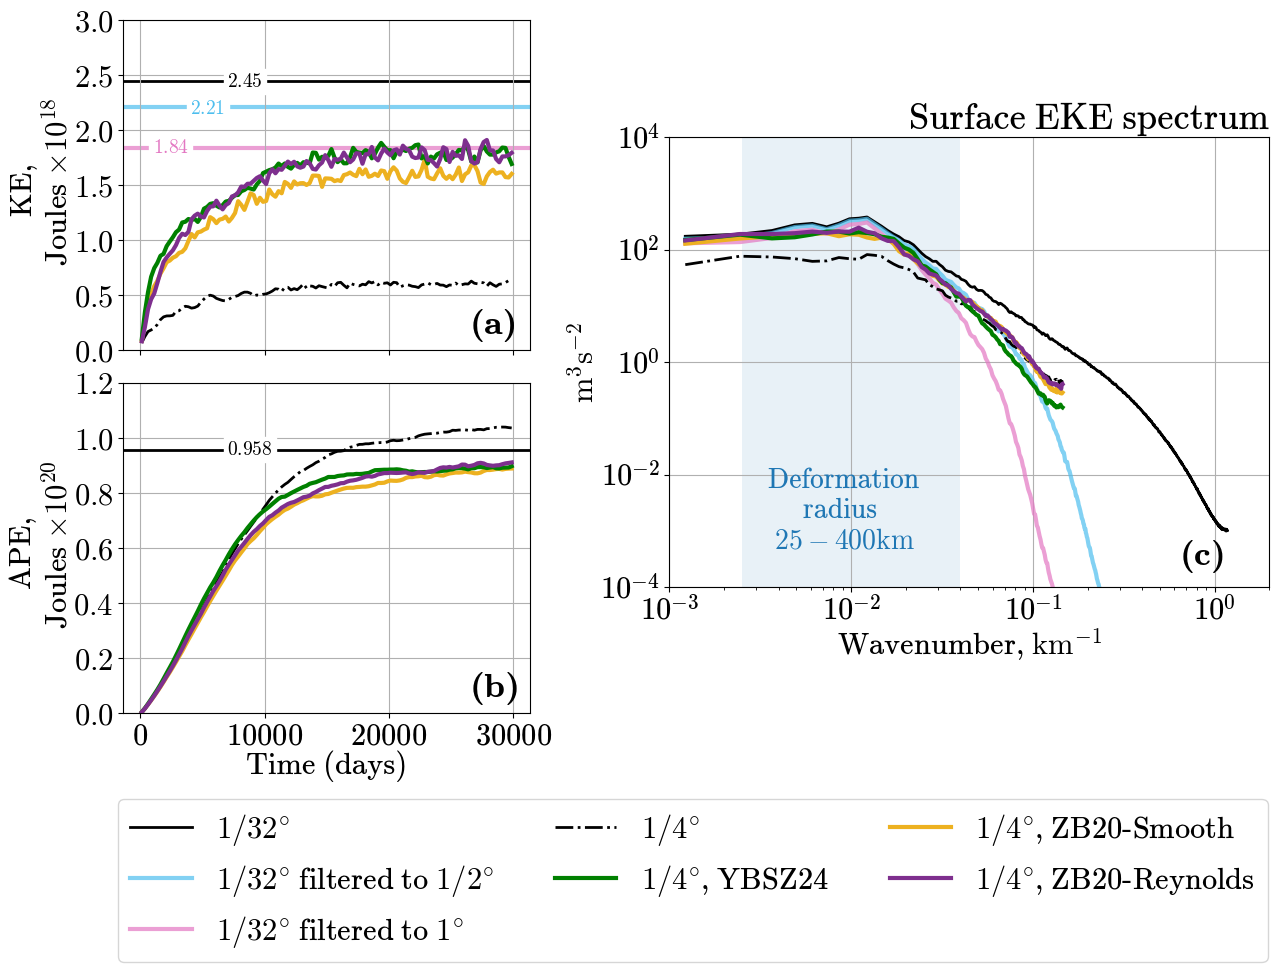

In [11]:
default_rcParams({'figure.subplot.wspace': 0.8, 'figure.subplot.hspace': 0.1,
                  'font.size': 22,  'axes.formatter.limits': (-5,5),
                 })
fig = plt.figure(figsize=(12,9))
import matplotlib.colors as mcolors

gs = fig.add_gridspec(2,4)

plt.sca(fig.add_subplot(gs[0, 0:2]))

plt.axhline(y=2.4482846764501053e+18, color='k', ls='-', lw=2, zorder=-1, label='$1/32^{\circ}$')
plt.axhline(y=2.2143647793008573e+18, color=lightblue, ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^{\circ}$ filtered to $1/2^{\circ}$')
plt.axhline(y=1.840343192972326e+18, color='tab:pink', ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^{\circ}$ filtered to $1^{\circ}$')

plt.text(7000,2.4e+18,'$2.45$', backgroundcolor='white', color='k', fontsize=14)
plt.text(4000,2.15e+18,'$2.21$', backgroundcolor='white', color=lightblue, fontsize=14)
plt.text(1000,1.8e+18,'$1.84$', backgroundcolor='white', color='tab:pink', fontsize=14)


KE(stats_R4).plot(color='k', ls='-.', label='$1/4^{\circ}$', lw=2)
#KE(stats_jh).plot(color='tab:red', label='$1/4^{\circ}$, JHAH15', lw=3, ls='--')
KE(stats_yankovsky_weak).plot(color='g', label='$1/4^{\circ}$, YBSZ24', lw=3, zorder=9)
KE(stats_smooth_weak).plot(color=yellow, label='$1/4^{\circ}$, ZB20-Smooth', lw=3)
KE(stats_reynolds_weak).plot(color=violet, label='$1/4^{\circ}$, ZB20-Reynolds', lw=3, ls='-', zorder=10)


plt.ylabel('KE, \n Joules $\\times 10^{18}$')
plt.ylim([0, 3e+18])
plt.yticks([0, 0.5e+18,1e+18,1.5e+18,2.0e+18,2.5e+18,3e+18], ['$0.0$', '$0.5$', '$1.0$', '$1.5$', '$2.0$', '$2.5$', '$3.0$'])
#plt.yticks([0, 0.6e+18,1.2e+18,1.8e+18,2.4e+18,3.0e+18], ['$0.0$', '$0.6$', '$1.2$', '$1.8$', '$2.4$', '$3.0$'])
plt.xlabel('')
plt.xticks([0, 10000, 20000, 30000], [None]*4)
plt.grid()

plt.legend(loc = 'lower center', fontsize=22, bbox_to_anchor=(1.4,-1.9), ncol=3)

plt.sca(fig.add_subplot(gs[1, 0:2]))
plt.axhline(y=9.584091697350959e+19, color='k', ls='-', lw=2)
plt.text(7000,9.4e+19,'$0.958$', backgroundcolor='white', color='k', fontsize=14)


APE(stats_R4).plot(color='k', label='$1/4^{\circ}$', lw=2, ls='-.')
#APE(stats_jh).plot(color='tab:red', label='$1/4^{\circ}$, JHAH15', lw=3, ls='--')
APE(stats_yankovsky_weak).plot(color='g', label='$1/4^{\circ}$, Yankovsky23', lw=3, ls='-', zorder=9)
APE(stats_smooth_weak).plot(color=yellow, label='$1/4^{\circ}$, ZB-Smooth', lw=3)
APE(stats_reynolds_weak).plot(color=violet, label='$1/4^{\circ}$, ZB-Reynolds', lw=3, ls='-', zorder=10)

plt.ylabel('APE, \n Joules $\\times 10^{20}$')
#plt.title('APE',loc='right')
plt.ylim([0, 1.2e+20])
plt.grid()

plt.yticks([0, 0.2e+20, 0.4e+20, 0.6e+20, 0.8e+20, 1.0e+20, 1.2e+20], ["$0.0$", "$0.2$", "$0.4$", "$0.6$", "$0.8$", "$1.0$", "$1.2$"])
#plt.yticks([0, 0.3e+20, 0.6e+20, 0.9e+20, 1.2e+20], ["$0.0$", "$0.3$", "$0.6$", "$0.9$", "$1.2$"])

plt.xlabel('Time (days)')


#plt.sca(fig.add_subplot(gs[0:2, 2:4]))
ax = plt.gcf().add_axes([0.58, 0.25, 0.5,0.5])
plt.sca(ax)
def sel(x):
    y = x.sel(yh=slice(None,None)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2)
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7)
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7)

sel(R4_spec).plot(color='k', lw=2, ls='-.')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', zorder=9)
sel(smooth_weak_spec).plot(color=yellow, lw=3)
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', zorder=10)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

Rd1 = 400
Rd2 = 25
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')


# k = np.array([1e-2,1e0])
# plt.plot(k, 3e-1*k**(-2))

#plt.gcf().align_labels()
set_letters(x=0.85, y=0.05, fontsize=24)
plt.savefig('Review-2/Figure-spectrum-24.pdf')

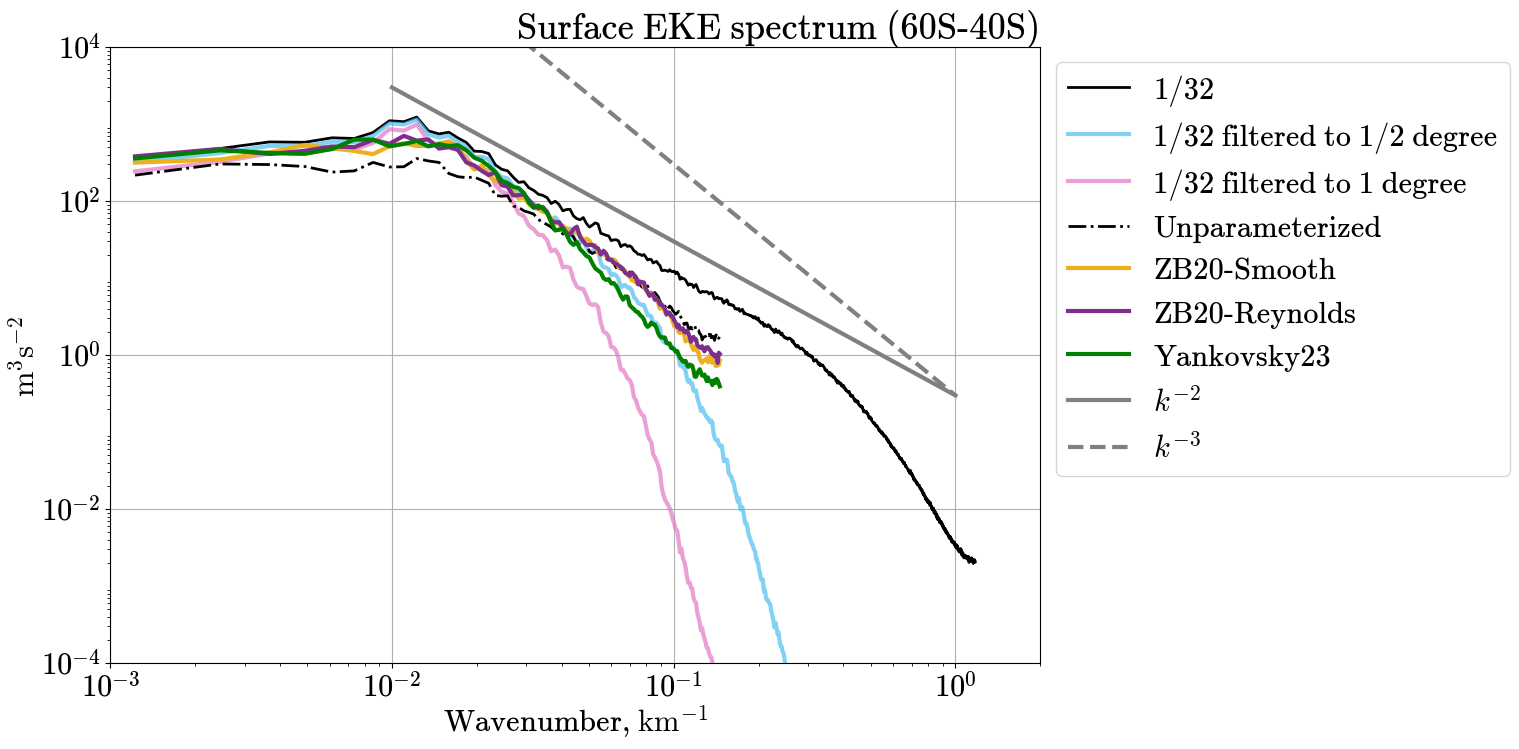

In [65]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(-60,-40)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1/2 degree')
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1 degree')

sel(R4_spec).plot(color='k', lw=2, ls='-.', label='Unparameterized')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(smooth_weak_spec).plot(color=yellow, lw=3, label='ZB20-Smooth')
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', label='ZB20-Reynolds')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', label='Yankovsky23')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (60S-40S)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)
k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-3), label='$k^{-3}$', color='gray', lw=3, ls='--')

Rd1 = 400
Rd2 = 25
#plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
#plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))

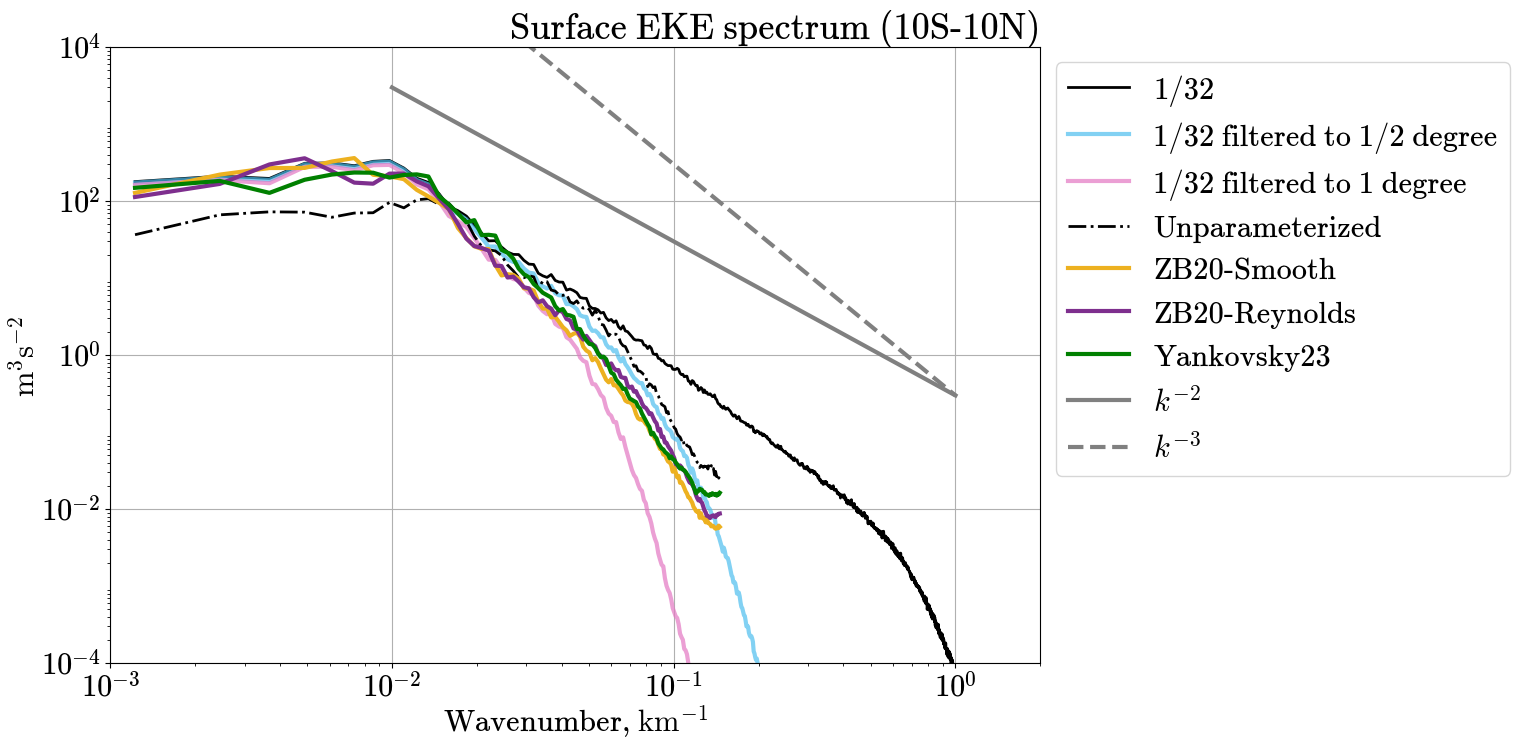

In [64]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(-10,10)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1/2 degree')
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1 degree')

sel(R4_spec).plot(color='k', lw=2, ls='-.', label='Unparameterized')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(smooth_weak_spec).plot(color=yellow, lw=3, label='ZB20-Smooth')
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', label='ZB20-Reynolds')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', label='Yankovsky23')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (10S-10N)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)
k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-3), label='$k^{-3}$', color='gray', lw=3, ls='--')


Rd1 = 400
Rd2 = 25
#plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
#plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))

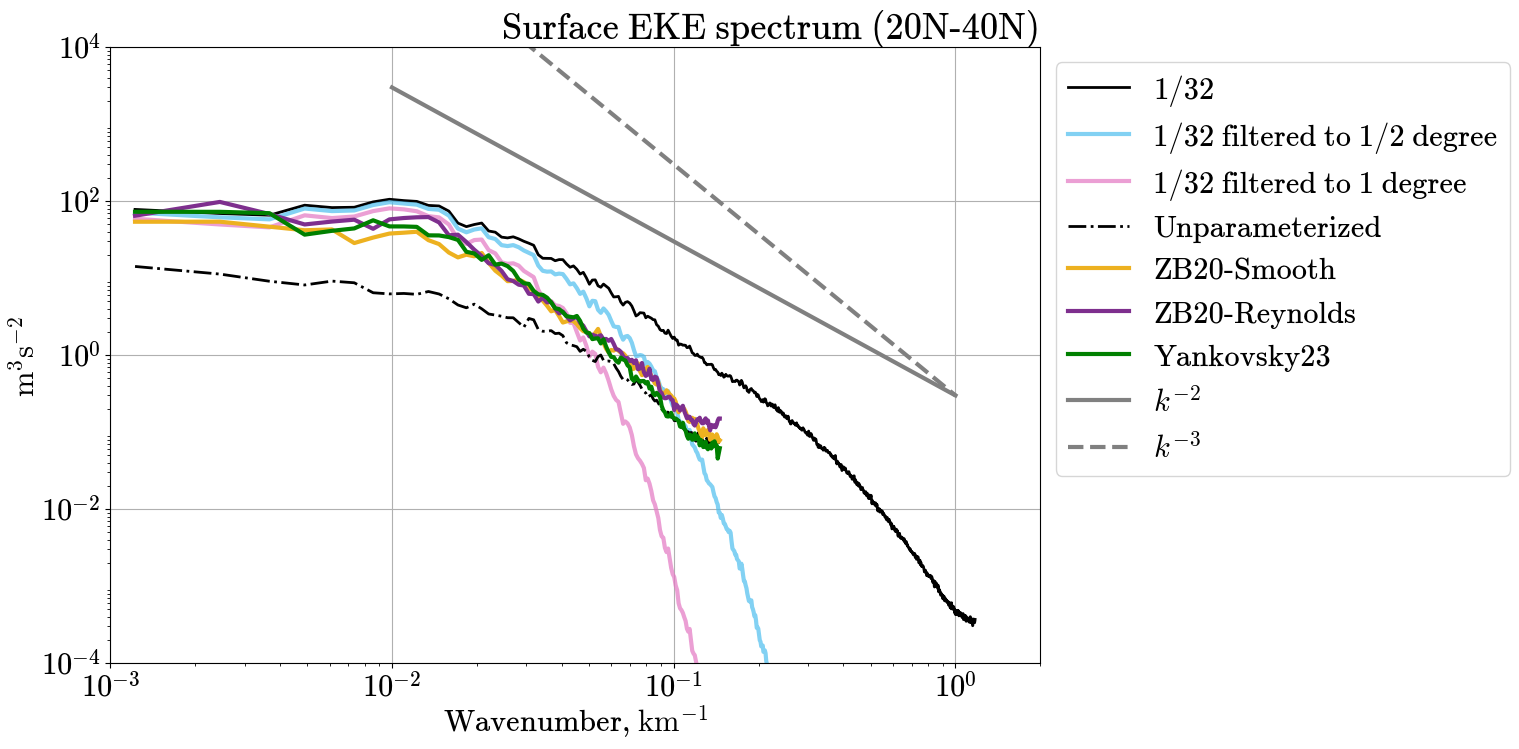

In [63]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(20,40)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1/2 degree')
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1 degree')

sel(R4_spec).plot(color='k', lw=2, ls='-.', label='Unparameterized')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(smooth_weak_spec).plot(color=yellow, lw=3, label='ZB20-Smooth')
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', label='ZB20-Reynolds')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', label='Yankovsky23')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (20N-40N)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)
k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-3), label='$k^{-3}$', color='gray', lw=3, ls='--')


Rd1 = 400
Rd2 = 25
#plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
#plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))

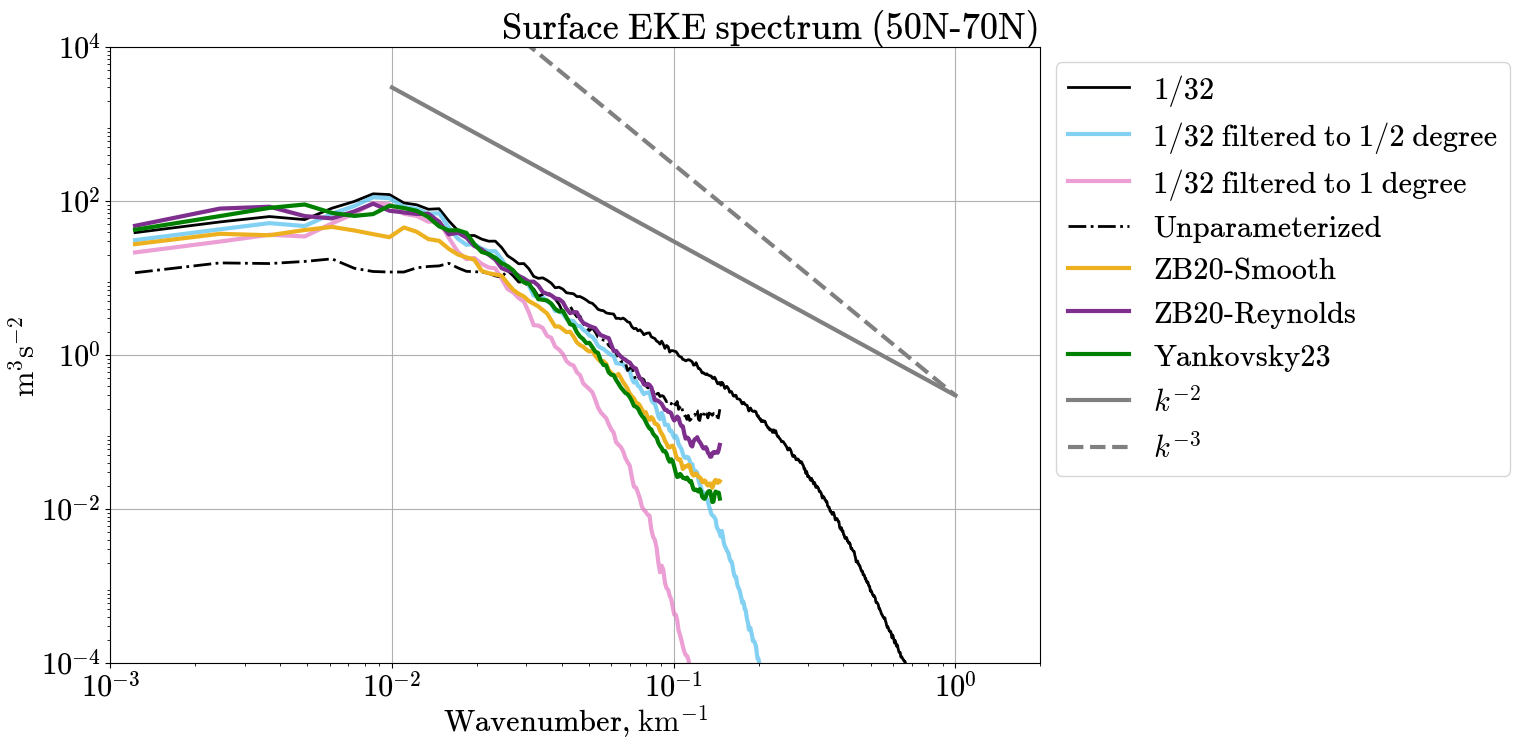

In [62]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(50,70)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1/2 degree')
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1 degree')

sel(R4_spec).plot(color='k', lw=2, ls='-.', label='Unparameterized')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(smooth_weak_spec).plot(color=yellow, lw=3, label='ZB20-Smooth')
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', label='ZB20-Reynolds')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', label='Yankovsky23')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (50N-70N)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)
k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-3), label='$k^{-3}$', color='gray', lw=3, ls='--')


Rd1 = 400
Rd2 = 25
#plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
#plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))

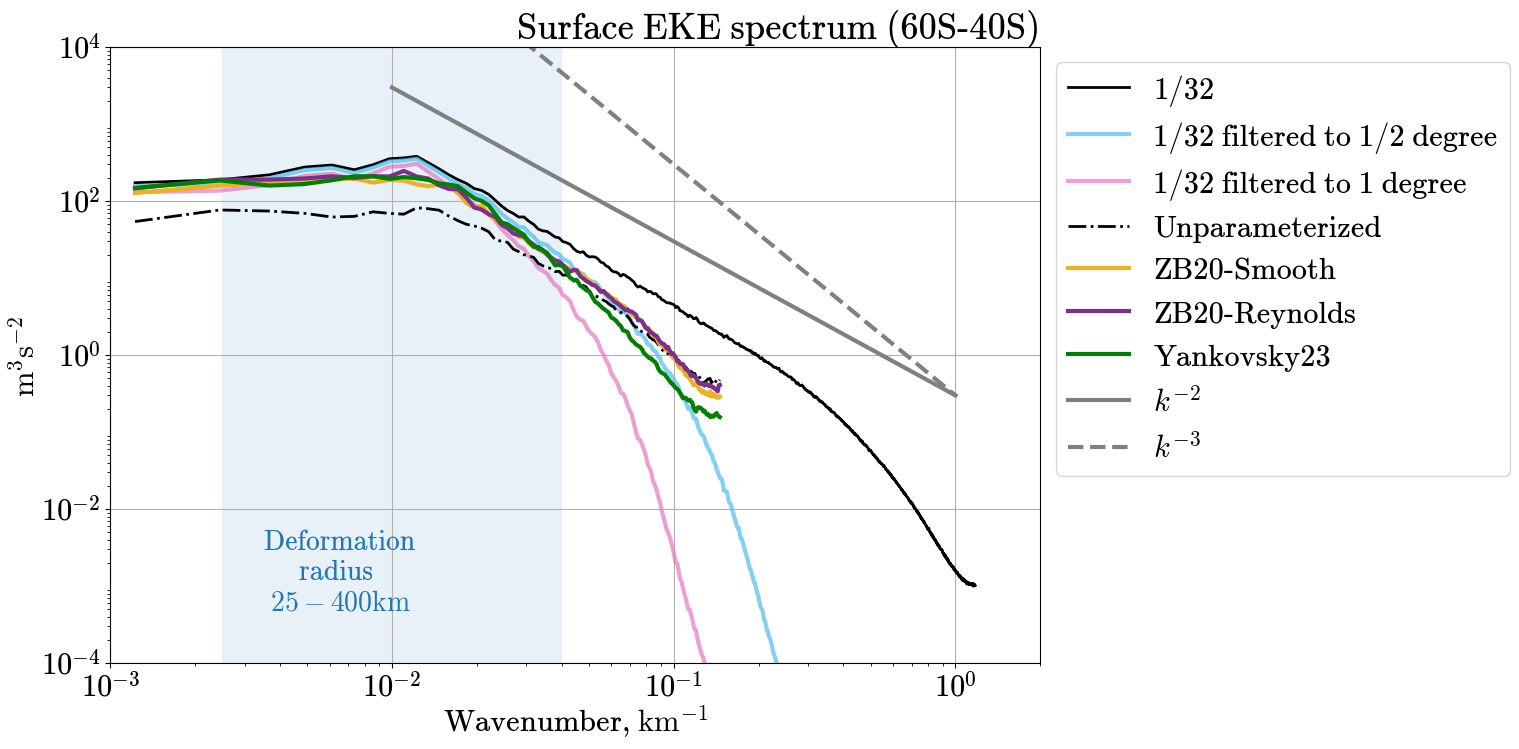

In [67]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(None,None)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1/2 degree')
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7, label='1/32 filtered to 1 degree')

sel(R4_spec).plot(color='k', lw=2, ls='-.', label='Unparameterized')
#sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(smooth_weak_spec).plot(color=yellow, lw=3, label='ZB20-Smooth')
sel(reynolds_weak_spec).plot(color=violet, lw=3, ls='-', label='ZB20-Reynolds')
sel(yankovsky_weak_spec).plot(color='g', lw=3, ls='-', label='Yankovsky23')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (60S-40S)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)
k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-3), label='$k^{-3}$', color='gray', lw=3, ls='--')

Rd1 = 400
Rd2 = 25
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))

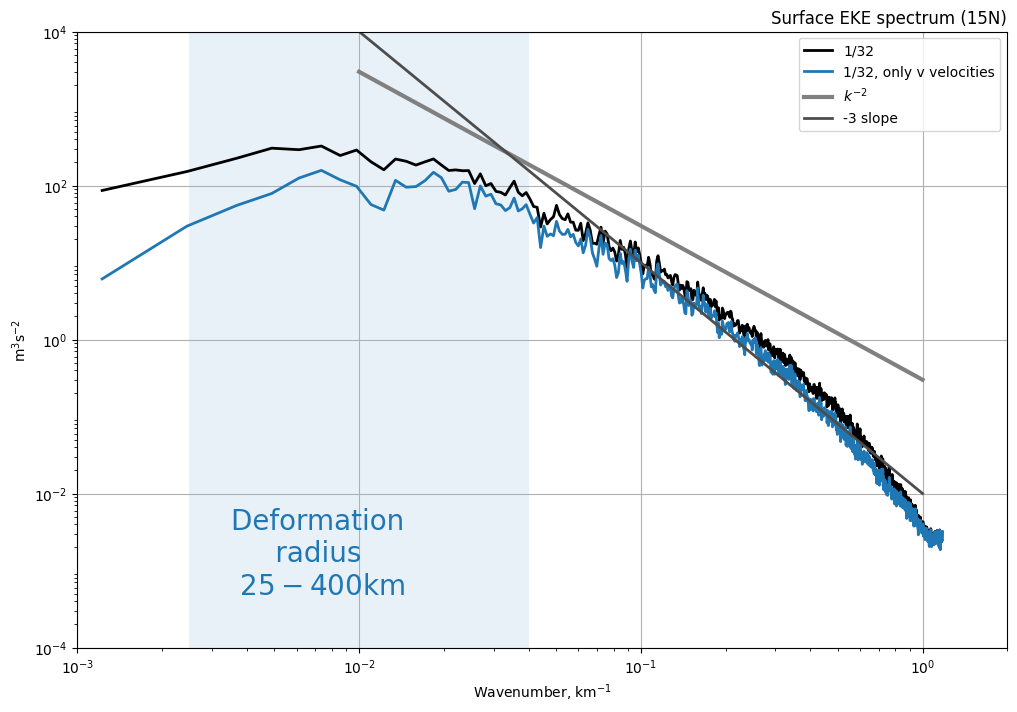

In [21]:
plt.figure(figsize=(12,8))
def sel(x):
    y = x.sel(yh=slice(14.5,15.5)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2, label='1/32')
sel(R32_spec_v).plot(color='tab:blue', ls='-', lw=2, label='1/32, only v velocities')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum (15N)', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

k = np.array([1e-2,1e0])
plt.plot(k, 3e-1*k**(-2), label='$k^{-2}$', color='gray', lw=3)

plt.plot([1e-2,1e0], [1e4,1e-2],color=[.3,.3,.3],linewidth=2,label='-3 slope')

Rd1 = 400
Rd2 = 25
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')

plt.legend(bbox_to_anchor=(1,1))